<a href="https://colab.research.google.com/github/vishwas-sri/SS_NOMA/blob/main/ES_EH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Important Library

In [12]:
# import pdb
import numpy as np
from sklearn import metrics as mt
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from scipy import special
# import tensorflow as tf
# tf.autograph.set_verbosity(1)

## Monte Carlo Simulation

In [13]:
# import numpy as np
variance = 2
# T = 100e-3  # Time span for one slot 100ms
# mu = 0.02   # Sensing duration ratio
# t = mu*T     # Sensing time
Pr = 0.5    # Probability of spectrum occupancy
Pw = -60    # Primary signal power in dBm
PowerTx = 10**(Pw/10)#*(1e-3)  # Transmitted power 0.1
Nw = -70   # Noise power in dBm -153 or -70
PowerNo = 10**(Nw/10)#*(1e-3)
g = 10**(-5)  # Path loss coefficeint 10^(-5)
# a = 4 #path loss factor
d = 500#np.array((500, 750, 1000))  # PU-SU distance in meters


def MCS(realize, samples, SU):
    Y = np.zeros((realize, SU))
    S = np.zeros((realize))
    SNR = np.zeros((SU,realize))

    noisePower = PowerNo*np.ones(SU)

    for k in range(realize):
        n = gaussianNoise(noisePower, samples)
        H = channel(SU,samples)
        X, S[k] = PUtx(samples, PowerTx, SU)
        PU = np.multiply(H.T, X)
        Z = PU + n
        SNR[:,k] = np.mean(np.abs(PU)**2,axis=1)/noisePower[0]
        Y[k,:] = np.sum(np.abs(Z)**2,axis=1)/(noisePower[0]*samples)

    meanSNR = np.mean(SNR[:,S==1],1)
    meanSNRdB = 10*np.log10(meanSNR)
    return Y, S, meanSNR


def PUtx(samples, TXPower, N):
    S = 0
    X = np.zeros(samples)
    if (np.random.rand(1) <= Pr):
        S = 1
        X = np.random.randn(samples) * np.sqrt(TXPower)
    X = np.vstack([X]*N)
    return [X, S]


def gaussianNoise(noisePower, samples):
    N = len(noisePower)
    n = np.random.randn(N, samples) * np.sqrt(noisePower[0])
    return n


def channel(N, samples):
    H = np.zeros(N)
    H = np.sqrt(-2 * variance * np.log(np.random.rand(N)))/np.sqrt(2)
    H = np.array(H*np.sqrt(g*(d)))  # Fading + path-loss (amplitude loss)
    # f = 500**(-a)
    # H = np.array(H*np.sqrt(f))
    H = np.vstack([H]*samples)
    return H


## Data Generation

In [14]:
SU = 3       # No. of SU
realize = 500
realize_test = 1000

Pd = []
Pf = []
samples = 500
X_train, y_train, _ = MCS(realize, samples, SU)
X_test, y_test, SNR = MCS(realize_test, samples, SU)

## ML aided Spectrum sening model
### (Including NCSS and CSS)

In [15]:

Linear_SVM = GridSearchCV(
                estimator=SVC(),
                param_grid=[{'C': [0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4,10, 100, 1000],
                    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                    'kernel': ['linear'], 'probability':[True]}],
                scoring='accuracy',
                n_jobs=-1, cv=10)

Linear_SVM.fit(X_train, y_train)

y_pred = Linear_SVM.predict(X_test)

# # for ROC, probability prediction
# y_pred2=Linear_SVM.predict_proba(X_test)
# y_pred2=y_pred2[:,1]

# fpr, tpr, _ = mt.roc_curve(y_test,  y_pred2)
# auc = mt.auc(fpr, tpr)





In [16]:
y_pred = Linear_SVM.predict(X_test)

In [52]:
PEh = []
Ptr = []
PEss = []

In [53]:

Eh = 0.1
k = 2
delta = [1,5,10,15,20]
Es = Eh/k
Eth = [x*k*Es for x in delta]
m = 20


for j in range(len(delta)):
  EH_count = 0
  tr_count = 0
  ESS_count = 0
  Eh1 = 0
  for i in range(realize_test):
    if Eh1 <= Eth[j] :
      if y_test[i] == 1:
        # do EH
        Eh1 = Eh1+k*Eh
        EH_count +=1
        # print("EH_count 1st ", EH_count)
    else:
      # do sensing
      Eh1 = Eh1-Es
      ESS_count += 1

      if y_pred[i] == 1:
        # do EH
        Eh1 = Eh1+k*Eh
        EH_count += 1
        # print("EH_count 2nd ", EH_count)
      else:
        # do transmission
        Eh1 = 0
        tr_count += 1
        # print("tr_count ",tr_count)
  PEss.append(ESS_count/1000)
  PEh.append(EH_count/1000)
  Ptr.append(tr_count/1000)





In [54]:
print(PEh)
print(Ptr)
print(PEss)

[0.473, 0.485, 0.487, 0.485, 0.49]
[0.26, 0.124, 0.07, 0.055, 0.04]
[0.473, 0.236, 0.137, 0.099, 0.089]


In [28]:
import matplotlib.pyplot as plt

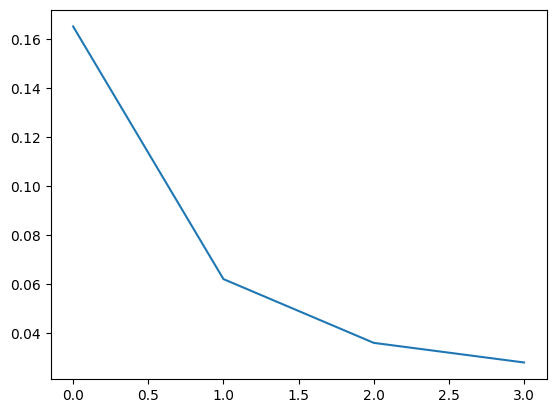

In [38]:
plt.plot(Ptr)

In [51]:
del PEh, Ptr, PEss